In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

label_file = "hirise-v3-cv-dataset/hirise-text-labels-3class.txt"
image_dir = "hirise-v3-cv-dataset/map-proj-v3"
save_dir = "saved_models_3class"

2023-10-30 12:41:30.946058: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-30 12:41:31.460074: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train_data = pd.read_csv(label_file, delimiter="\s+")
Y = train_data[['label']]
print(Y)

kf = KFold(n_splits = 5)
                         
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 

             label
0     slope_streak
1     slope_streak
2     slope_streak
3     slope_streak
4     slope_streak
...            ...
5224  swiss_cheese
5225  swiss_cheese
5226  swiss_cheese
5227  swiss_cheese
5228  swiss_cheese

[5229 rows x 1 columns]


In [3]:
idg = ImageDataGenerator(rescale=1./255)
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [4]:
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
def create_new_model():
    model = Sequential()

    # 1st Convolutional Layer
    model.add(Conv2D(filters=96, input_shape=(227,227,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
    model.add(Activation('relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

    # 2nd Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

    # 3rd Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))

    # 4th Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))

    # 5th Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

    # Passing it to a Fully Connected layer
    model.add(Flatten())
    # 1st Fully Connected Layer
    model.add(Dense(4096, input_shape=(224*224*3,)))
    model.add(Activation('relu'))
    # Add Dropout to prevent overfitting
    model.add(Dropout(0.5))

    # 2nd Fully Connected Layer
    model.add(Dense(4096))
    model.add(Activation('relu'))
    # Add Dropout
    model.add(Dropout(0.5))

    # 3rd Fully Connected Layer
    model.add(Dense(1000))
    model.add(Activation('relu'))
    # Add Dropout
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(3))
    model.add(Activation('softmax'))
    return model

# The cell below trains the data and takes 1 hour 15 min. Don't run if you already have saved models!

In [ ]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

save_dir = 'saved_models_3class/'
fold_var = 1
n=5229
num_epochs = 10
img_width = 227
img_height = 227

for train_index, val_index in kf.split(np.zeros(n),Y):
	training_data = train_data.iloc[train_index]
	validation_data = train_data.iloc[val_index]
	
	train_data_generator = idg.flow_from_dataframe(training_data, directory = image_dir,
						       x_col = "filename", y_col = "label", target_size=(img_height, img_width),
						       class_mode = "categorical", shuffle = True)
	valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = image_dir,
							x_col = "filename", y_col = "label", target_size=(img_height, img_width),
							class_mode = "categorical", shuffle = True)
	
	# CREATE NEW MODEL
	model = create_new_model()
	# COMPILE NEW MODEL
	model.compile(loss='categorical_crossentropy',
		      optimizer='adam',
		      metrics=['accuracy'])
	
	# CREATE CALLBACKS
	checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
	callbacks_list = [checkpoint]
	# There can be other callbacks, but just showing one because it involves the model name
	# This saves the best model
	# FIT THE MODEL
	history = model.fit(train_data_generator,
			    epochs=num_epochs,
			    callbacks=callbacks_list,
			    validation_data=valid_data_generator)
	#PLOT HISTORY
	#		:
	#		:
	
	# LOAD BEST MODEL to evaluate the performance of the model
	model.load_weights(save_dir + "/model_" + str(fold_var) + ".h5")
	
	results = model.evaluate(valid_data_generator)
	results = dict(zip(model.metrics_names,results))
	
	VALIDATION_ACCURACY.append(results['accuracy'])
	VALIDATION_LOSS.append(results['loss'])
	
	tf.keras.backend.clear_session()
	
	fold_var += 1

# Evaluate saved model performance

In [5]:
def load_trained_model(model_file):
    model = create_new_model()
    return model.load_weights(model_file)

Found 4183 validated image filenames belonging to 3 classes.
Found 1046 validated image filenames belonging to 3 classes.


2023-10-30 12:41:45.571206: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-30 12:41:45.576282: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-30 12:41:45.576506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

 9/33 [=======>......................] - ETA: 0s

2023-10-30 12:41:47.667577: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


33/33 [==============================] - 2s 29ms/step


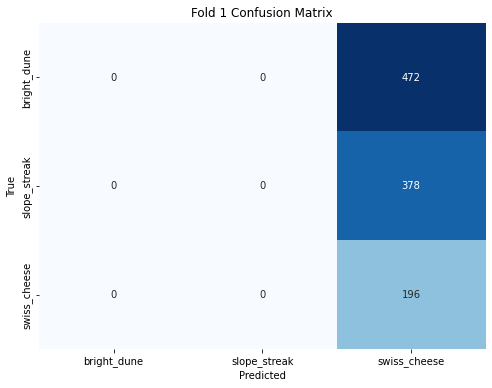

Found 4183 validated image filenames belonging to 3 classes.
Found 1046 validated image filenames belonging to 3 classes.
33/33 [==============================] - 1s 25ms/step


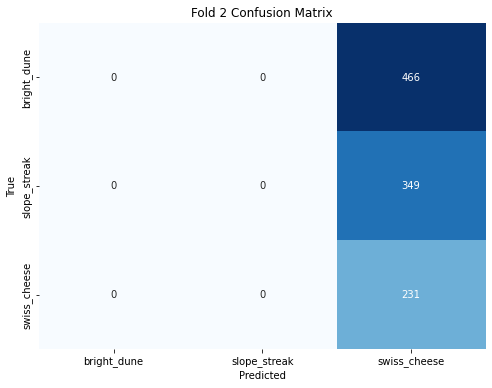

Found 4183 validated image filenames belonging to 3 classes.
Found 1046 validated image filenames belonging to 3 classes.
33/33 [==============================] - 1s 25ms/step


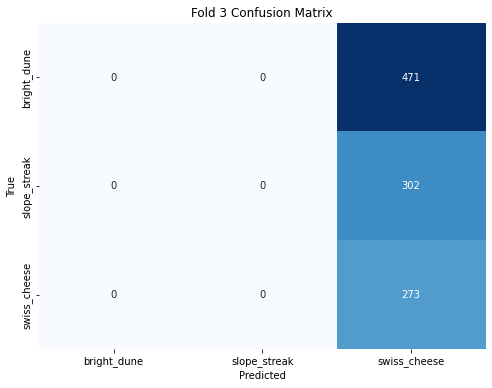

Found 4183 validated image filenames belonging to 3 classes.
Found 1046 validated image filenames belonging to 3 classes.
33/33 [==============================] - 1s 26ms/step


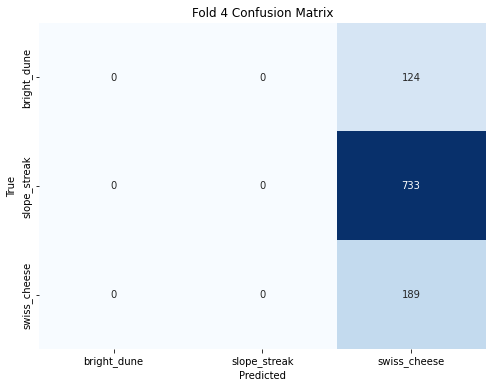

Found 4184 validated image filenames belonging to 3 classes.
Found 1045 validated image filenames belonging to 3 classes.
33/33 [==============================] - 1s 31ms/step


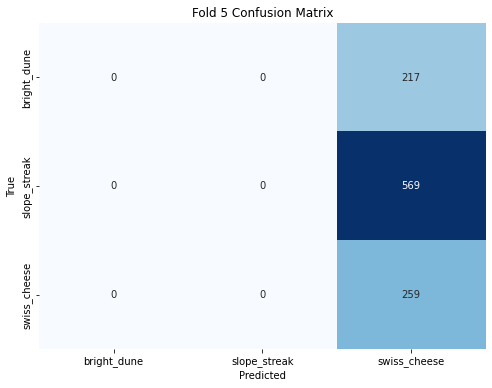

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

fold_var = 1
n=5229
num_epochs = 10
img_width = 227
img_height = 227

model = create_new_model()

for train_index, val_index in kf.split(np.zeros(n),Y):
    training_data = train_data.iloc[train_index]
    validation_data = train_data.iloc[val_index]
	
    train_data_generator = idg.flow_from_dataframe(training_data, directory = image_dir,
						       x_col = "filename", y_col = "label", target_size=(img_height, img_width),
						       class_mode = "categorical", shuffle = True)
    valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = image_dir,
							x_col = "filename", y_col = "label", target_size=(img_height, img_width),
							class_mode = "categorical", shuffle = True)
    
    class_labels = list(valid_data_generator.class_indices.keys())
    
    load_trained_model(save_dir + "/model_" + str(fold_var) + ".h5")
    
    # perform validation predictions
    val_predictions = model.predict(valid_data_generator)
    # Convert predicted probabilities to class labels
    predicted_labels = np.argmax(val_predictions, axis=1)
    
    # generate confusion matrix
    confusion = confusion_matrix(valid_data_generator.classes, predicted_labels)
    
    # plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Fold ' + str(fold_var) +  ' Confusion Matrix')
    plt.show()
    
    fold_var += 1